In [2]:
import numpy as np # linear algebra
# version of panda should be 0.25.1 because of .ix function
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# pip install opencv-python
import cv2

# pip install tqdm
from tqdm import tqdm

from sklearn.model_selection import KFold
import time


In [3]:

# Pre-processing the train and test data

x_train = []
x_test = []
y_train = []

df_train = pd.read_csv('./train_v2.csv')
# df_test = pd.read_csv('./dataset/sample_submission_v2.csv')

flatten = lambda l: [item for sublist in l for item in sublist]
labels = list(set(flatten([l.split(' ') for l in df_train['tags'].values])))


In [4]:

labels = ['blow_down',
          'bare_ground',
          'conventional_mine',
          'blooming',
          'cultivation',
          'artisinal_mine',
          'haze',
          'primary',
          'slash_burn',
          'habitation',
          'clear',
          'road',
          'selective_logging',
          'partly_cloudy',
          'agriculture',
          'water',
          'cloudy']

label_map = {'agriculture': 14,
             'artisinal_mine': 5,
             'bare_ground': 1,
             'blooming': 3,
             'blow_down': 0,
             'clear': 10,
             'cloudy': 16,
             'conventional_mine': 2,
             'cultivation': 4,
             'habitation': 9,
             'haze': 6,
             'partly_cloudy': 13,
             'primary': 7,
             'road': 11,
             'selective_logging': 12,
             'slash_burn': 8,
             'water': 15}


In [5]:

for f, tags in tqdm(df_train.values[:15000], miniters=1000):
    img = cv2.imread('./train-jpg/{}.jpg'.format(f))
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1
    x_train.append(cv2.resize(img, (128, 128)))
    y_train.append(targets)


y_train = np.array(y_train, np.uint8)
x_train = np.array(x_train, np.float32) / 255.
# x_test = np.array(x_test, np.float32) / 255.

print(x_train.shape)
print(y_train.shape)


100%|██████████| 15000/15000 [00:26<00:00, 568.02it/s]


(15000, 128, 128, 3)
(15000, 17)


In [5]:
from tensorflow.keras import backend as K

def fbeta(y_true, y_pred, beta=2):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    
    y_pred = K.clip(y_pred, 0, 1)
    
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=1)
    fp = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)), axis=1)
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=1)
    
    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())
    
    bb = beta ** 2
    result = K.mean((1 + bb) * (p * r) / (bb * p + r + K.epsilon()))
    
    return result

In [9]:

###############################

from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import fbeta_score

X_train, X_valid, Y_train, Y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

print('Training data shape:', X_train.shape, Y_train.shape)
print('Validation data shape:', X_valid.shape, Y_valid.shape)

# kfold_weights_path = os.path.join('', 'weights.keras')

# base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
# for layer in base_model.layers:
#     layer.trainable = False

# for layer_name in ['block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool']:
#     base_model.get_layer(layer_name).trainable = True

# model = Sequential([
#     base_model,
#     Flatten(),
#     Dense(128, activation='relu'),
#     Dropout(0.2),
#     Dense(17, activation='sigmoid')
# ])

# model.compile(loss='binary_crossentropy',
#               optimizer='adam',
#               metrics=[fbeta])


Training data shape: (12000, 128, 128, 3) (12000, 17)
Validation data shape: (3000, 128, 128, 3) (3000, 17)


In [7]:

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, verbose=0),
    ModelCheckpoint(kfold_weights_path, monitor='val_loss', save_best_only=True, verbose=0)
]


history = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid),
            batch_size=128, verbose=1, epochs=40, callbacks=callbacks,
            shuffle=True)

print(model.summary())

if os.path.isfile(kfold_weights_path):
    model.load_weights(kfold_weights_path)

p_valid = model.predict(X_valid, batch_size=128, verbose=2)
print("F beta score: " + str(fbeta_score(Y_valid, np.array(p_valid) > 0.2, beta=2, average='samples')))

Epoch 1/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 646s 7s/step - fbeta: 0.6607 - loss: 0.3149 - val_fbeta: 0.7686 - val_loss: 0.1560
Epoch 2/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 626s 7s/step - fbeta: 0.7981 - loss: 0.1623 - val_fbeta: 0.8109 - val_loss: 0.1411
Epoch 3/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 640s 7s/step - fbeta: 0.8235 - loss: 0.1438 - val_fbeta: 0.8595 - val_loss: 0.1267
Epoch 4/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 642s 7s/step - fbeta: 0.8434 - loss: 0.1315 - val_fbeta: 0.8530 - val_loss: 0.1226
Epoch 5/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 631s 7s/step - fbeta: 0.8554 - loss: 0.1229 - val_fbeta: 0.8410 - val_loss: 0.1224
Epoch 6/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 633s 7s/step - fbeta: 0.8544 - loss: 0.1201 - val_fbeta: 0.8532 - val_loss: 0.1220
Epoch 7/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 636s 7s/step - fbeta: 0.8656 - loss: 0.1135 - val_fbeta: 0.8619 - val_loss: 0.1198
Epoch 8/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 618s 7s/step - fbeta: 0.8749 - loss: 0.1078 - val_fbeta: 0.8535 - val_loss: 0.1215
Epoch 9/40
94/94 ━━━━━━━━━━━━━━━

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 17)             │         2,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,026,229 (122.17 MB)

 Trainable params: 8,130,321 (31.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

 Optimizer params: 16,260,644 (62.03 MB)

None
24/24 - 106s - 4s/step
F beta score: 0.898941900021483


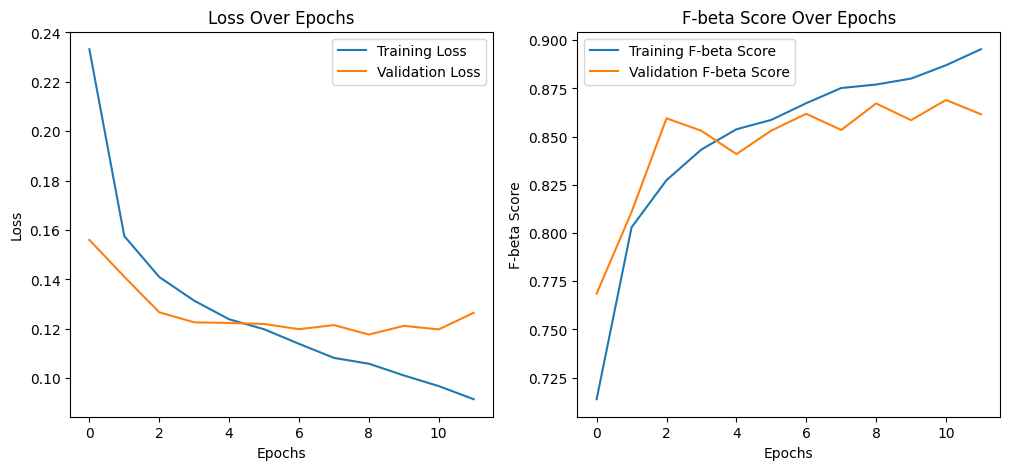

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot F-beta score
plt.subplot(1, 2, 2)
plt.plot(history.history['fbeta'], label='Training F-beta Score')
plt.plot(history.history['val_fbeta'], label='Validation F-beta Score')
plt.title('F-beta Score Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F-beta Score')
plt.legend()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
Predicted Classes: ['cloudy']


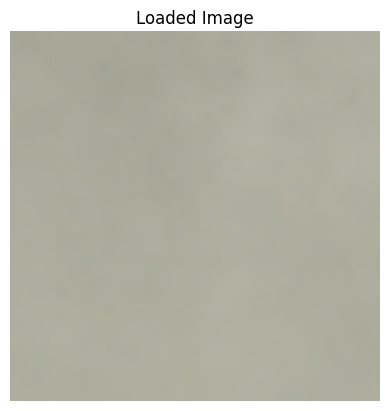

In [12]:
# Predict the class probabilities
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

img_path = './train-jpg/train_1969.jpg'  
img = image.load_img(img_path, target_size=(128, 128)) 
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  
img_array /= 255.0 
predictions = model.predict(img_array)
predicted_classes = (predictions > 0.5).astype(int)[0] 
print(predicted_classes)
class_names = [labels[i] for i in range(len(predicted_classes)) if  predicted_classes[i] > 0]
print("Predicted Classes:", class_names)


plt.imshow(img)
plt.axis('off')  # Hide axis
plt.title('Loaded Image')
plt.show()

94/94 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step


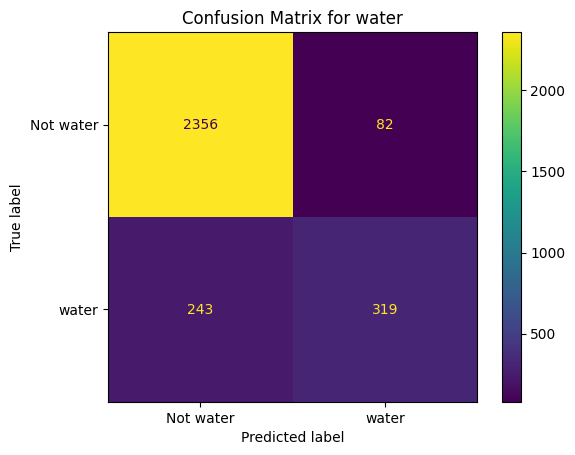

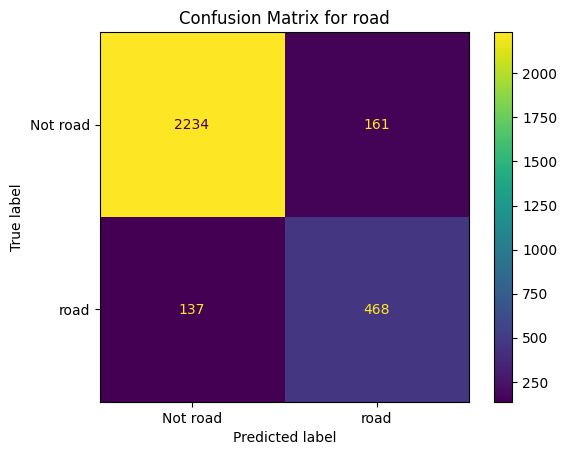

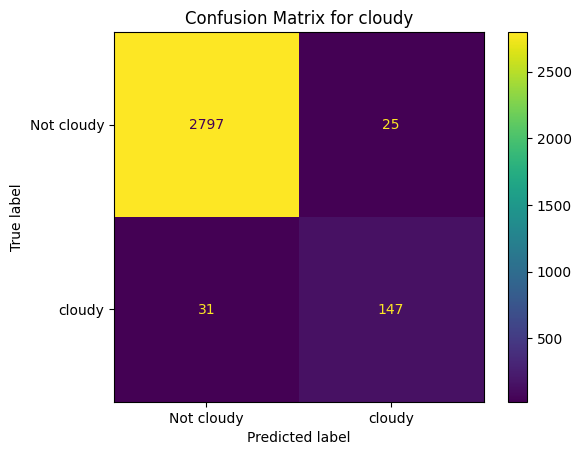

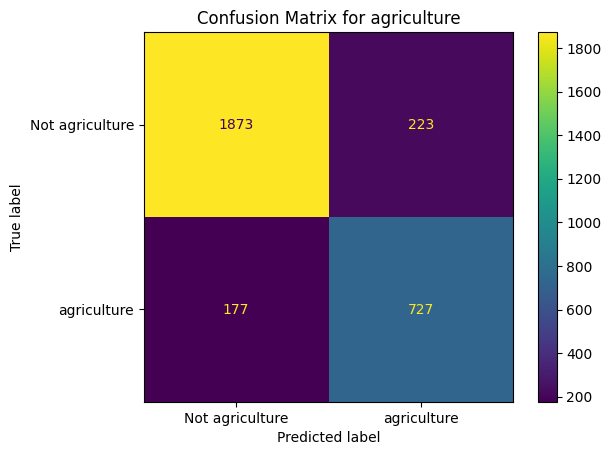

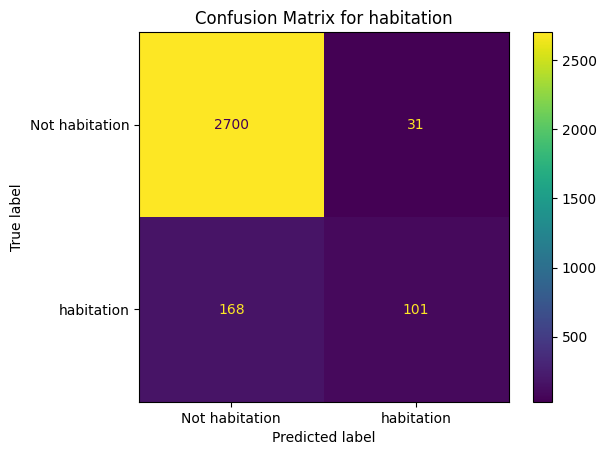

In [14]:
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, accuracy_score, multilabel_confusion_matrix
    

selected_classes = ['water', 'road', 'cloudy', 'agriculture', 'habitation']
selected_indices = [labels.index(label) for label in selected_classes]

y_pred = model.predict(X_valid)
y_pred = np.round(y_pred)  # Convert probabilities to 0 or 1

mcm = multilabel_confusion_matrix(Y_valid, y_pred)
for i, label in enumerate(labels):
    f1 = f1_score(Y_valid[:, i], y_pred[:, i])
    acc = accuracy_score(Y_valid[:, i], y_pred[:, i])

for i in selected_indices:
    cm = mcm[i]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'Not {labels[i]}', labels[i]])
    disp.plot()
    plt.title(f'Confusion Matrix for {labels[i]}')
    plt.show()

In [14]:
from tensorflow.keras import backend as K
import tensorflow as tf

@tf.keras.utils.register_keras_serializable()
def fbeta(y_true, y_pred, beta=2):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    
    y_pred = K.clip(y_pred, 0, 1)
    
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=1)
    fp = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)), axis=1)
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=1)
    
    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())
    
    bb = beta ** 2
    result = K.mean((1 + bb) * (p * r) / (bb * p + r + K.epsilon()))
    
    return result

In [7]:
from tensorflow.keras.models import load_model
from sklearn.metrics import fbeta_score


model = load_model('vggv3.keras', custom_objects={'fbeta': fbeta})

94/94 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step
F-beta Score (average="samples"): 0.8678
F-beta custom: 0.8678
Accuracy: 0.5823


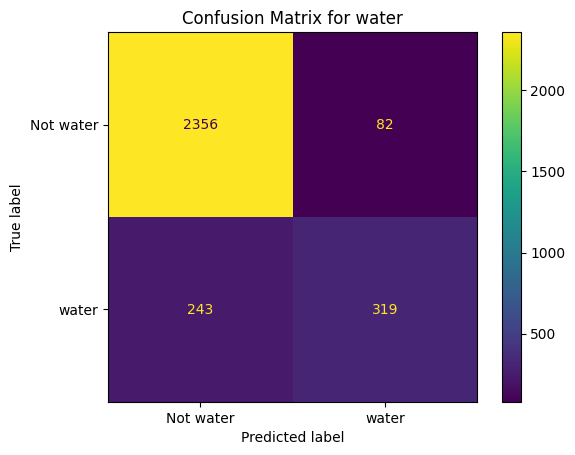

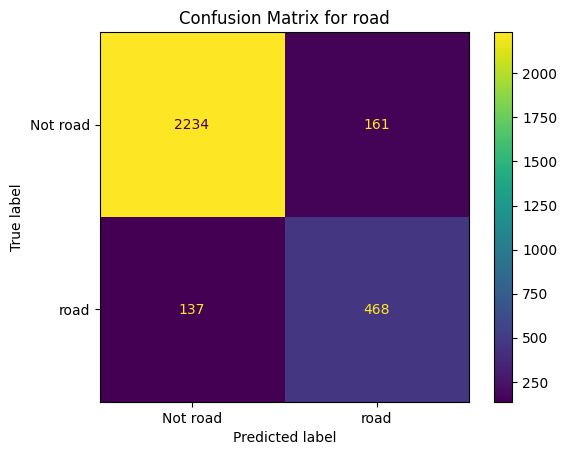

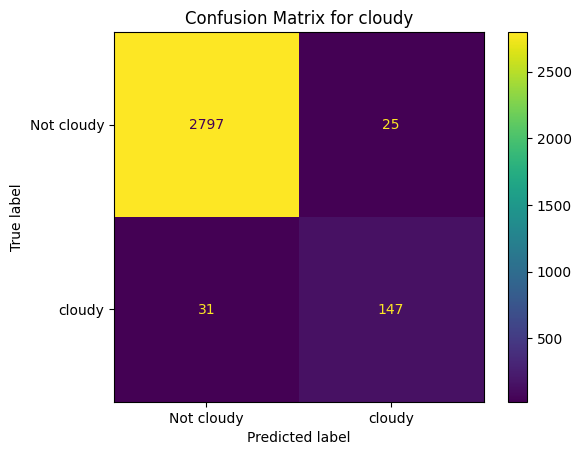

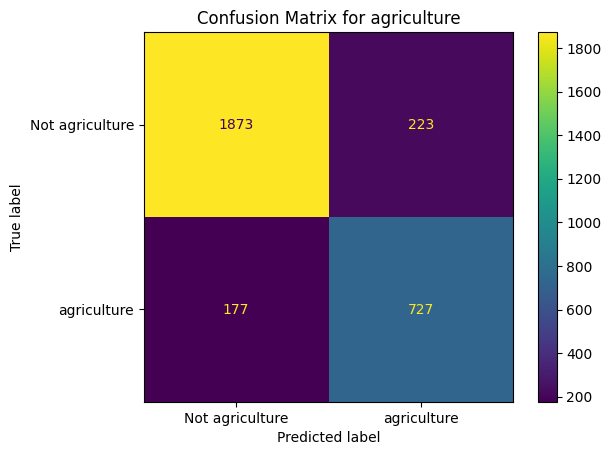

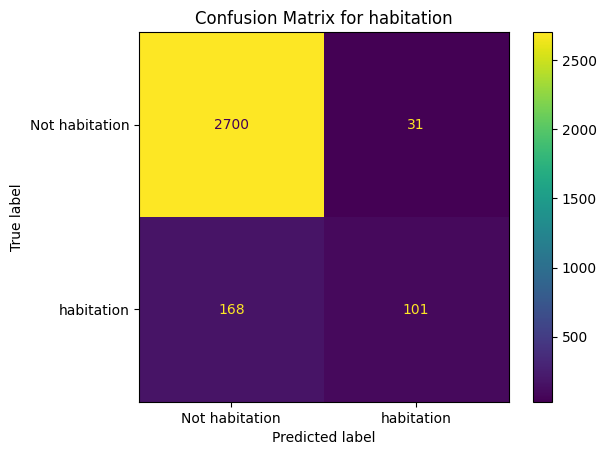

In [15]:
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay, fbeta_score, accuracy_score
import matplotlib.pyplot as plt

# Define the beta value for the F-beta score (e.g., beta=2 to emphasize recall)
beta = 2

# Predict and round the predictions
y_pred = model.predict(X_valid)
y_pred = np.round(y_pred)  # Convert probabilities to 0 or 1

# Calculate F-beta Score for the entire model
fbeta_result = fbeta_score(Y_valid, y_pred, beta=beta, average='samples')  # Change 'macro' to 'micro' or 'weighted' as needed
accuracy = accuracy_score(Y_valid, y_pred)
fbeta_custom = fbeta(Y_valid, y_pred)
print(f'F-beta Score (average="samples"): {fbeta_result:.4f}')
print(f'F-beta custom: {fbeta_custom:.4f}')
print(f'Accuracy: {accuracy:.4f}')

# Calculate multilabel confusion matrix
mcm = multilabel_confusion_matrix(Y_valid, y_pred)

# Display confusion matrices for selected classes (if needed)
selected_classes = ['water', 'road', 'cloudy', 'agriculture', 'habitation']
selected_indices = [labels.index(label) for label in selected_classes]

for i in selected_indices:
    cm = mcm[i]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'Not {labels[i]}', labels[i]])
    disp.plot()
    plt.title(f'Confusion Matrix for {labels[i]}')
    plt.show()

TypeError: 'numpy.float64' object is not callable